#**Aljazeera dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gensim
# load the AraVec model
model = gensim.models.Word2Vec.load("/content/drive/MyDrive/DataMem/full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.mdl")
print("We've",len(model.wv.index2word),"vocabularies")

We've 1476715 vocabularies


# Nouvelle section

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import nltk
#import nltk as nlp
import string
import re


In [ ]:
df= pd.read_excel('/content/drive/MyDrive/DataMem/dataset.xlsx')

In [ ]:
df.Class.value_counts()

1    26039
0     5653
Name: Class, dtype: int64

In [ ]:
!pip install  alphabet_detector 


  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-cp37-none-any.whl size=2446 sha256=ba1acebf5d54ca39c94e0dd374dc9c6e1d1fadfb0faa5c720c2359f7d8315a2b
  Stored in directory: /root/.cache/pip/wheels/75/a7/c3/faf515469622e565475fc96983418ba6e03f6a0f73755cd892
Successfully built alphabet-detector


In [ ]:
# Pretraitement data
 
import re
import string
from alphabet_detector import AlphabetDetector
from bs4 import BeautifulSoup
#definition des diactrics
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

#Suppression des diactrics
def remove_diacritics(text):  #إزالة علامات التشكيل *
    text = re.sub(arabic_diacritics, '', text)
    return text

#Suppression de punctuations
def remove_punctuation(s): 
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»" + "!"
    translator = str.maketrans('', '', my_punctuations)
    return s.translate(translator)


def remove_punctuation2(s): # replace punctuation with space
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    replace_table = str.maketrans(my_punctuations,  ' '*len(my_punctuations))
    return s.translate(replace_table)

#remove text change from html to text
def html2text(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()


#remove other letters
def remove_links(text):
 
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

# remove empty lines
def remove_empty_lines(text):
    lines = [s.rstrip() for s in text.split("\n") if s.rstrip()]
    return '\n'.join(lines)


def remove_repeating_char(text):
    # return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)  # keep 2 repeat

#remove any othe language letters
def keep_only_arabic(text):
    ad = AlphabetDetector()
    clean_lines = list()
    for line in text.splitlines():
        clean_line = list()
        for word in line.split():
            if len(word) > 1:
                if ad.is_arabic(word):
                    if word.isalpha():
                        clean_line.append(word)
        clean_lines.append(' '.join(clean_line))
    return '\n'.join(clean_lines)


def clean_doc(text):
    text = html2text(text)
  
    text = text.replace('\\', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    clean_text = remove_links(text)
    clean_text = remove_diacritics(clean_text)
    clean_text = remove_punctuation2(clean_text)
    clean_text = keep_only_arabic(clean_text)
    clean_text = remove_repeating_char(clean_text)
    clean_text = remove_empty_lines(clean_text)
    return clean_text


In [ ]:
#df['body'].values.tolist()
df['Tweet']=df['Tweet'].apply(clean_doc)

In [ ]:

from sklearn.model_selection import train_test_split
X = df['Tweet'].astype(str).values
y= df['Class'].values
   
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
max_num_words = 25354
max_length =40

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_val)

list_tokenized_train[1]

[918, 918, 33, 262, 918]

In [ ]:
X_tr = pad_sequences(list_tokenized_train, maxlen=max_length, padding='post')
X_tes = pad_sequences(list_tokenized_test, maxlen=max_length, padding='post')
X_tr[1]

array([918, 918,  33, 262, 918,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [ ]:
# Identify max length of reviews
max_length = 0
for review_number in range(len(list_tokenized_train)):
  numberofwords=len(list_tokenized_train [review_number])
  if (numberofwords) > (max_length):
    max_length = numberofwords
print(max_length)

40


In [ ]:
# Show the vocabulory
word_index = tokenizer.word_index
print(tokenizer.word_index)
print('Found %s unique tokens.' % len(word_index))

{'من': 1, 'في': 2, 'على': 3, 'الله': 4, 'لا': 5, 'يا': 6, 'ان': 7, 'هذا': 8, 'ما': 9, 'عن': 10, 'كل': 11, 'هو': 12, 'أن': 13, 'ولا': 14, 'مع': 15, 'الى': 16, 'لم': 17, 'هذه': 18, 'مصر': 19, 'الا': 20, 'الدولة': 21, 'الجزيرة': 22, 'كان': 23, 'حتى': 24, 'هه': 25, 'هل': 26, 'او': 27, 'السعودية': 28, 'السيسي': 29, 'اللهم': 30, 'الذي': 31, 'المسلمين': 32, 'والله': 33, 'العرب': 34, 'التي': 35, 'هم': 36, 'الشعب': 37, 'ايران': 38, 'هي': 39, 'لو': 40, 'إلى': 41, 'اليمن': 42, 'بعد': 43, 'بل': 44, 'انت': 45, 'داعش': 46, 'ليس': 47, 'لن': 48, 'أو': 49, 'له': 50, 'غير': 51, 'ومن': 52, 'العراق': 53, 'سوريا': 54, 'العربية': 55, 'عليه': 56, 'فقط': 57, 'فى': 58, 'كما': 59, 'قبل': 60, 'دولة': 61, 'العالم': 62, 'هؤلاء': 63, 'مثل': 64, 'لماذا': 65, 'لهم': 66, 'اسرائيل': 67, 'قطر': 68, 'اذا': 69, 'الذين': 70, 'قال': 71, 'علي': 72, 'وليس': 73, 'بين': 74, 'لكن': 75, 'يجب': 76, 'ضد': 77, 'الاسلام': 78, 'ولكن': 79, 'انه': 80, 'قتل': 81, 'بشار': 82, 'الخليج': 83, 'امريكا': 84, 'إلا': 85, 'كيف': 86, 'يعني': 87, '

In [ ]:
len(list_tokenized_train)

25353

In [ ]:
X_tr.shape

(25353, 40)

In [ ]:
model["الجزائر"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 7.03658164e-01, -1.17206454e+00,  5.20509899e-01,  1.79336345e+00,
       -8.71224701e-01, -7.36100554e-01,  4.82115835e-01, -1.24040973e+00,
       -1.07708979e+00,  1.25925314e+00, -1.83763373e+00,  4.54997092e-01,
       -8.53953481e-01,  3.38911712e-01, -1.61027372e+00, -1.09810233e+00,
       -5.55308238e-02,  6.90826774e-01,  5.31724334e-01,  1.81677234e+00,
        4.46090937e-01,  6.63624406e-01,  7.58774519e-01,  9.54323828e-01,
       -1.52540123e+00,  8.54157805e-01,  8.68102163e-03, -1.54378521e+00,
        1.43151319e+00,  4.97710705e-01, -3.91972452e-01,  9.24101293e-01,
        1.47198272e+00, -1.13544583e+00, -3.78376208e-02,  9.40275967e-01,
       -8.52677882e-01, -4.73342806e-01, -2.84870535e-01, -2.47993708e+00,
       -5.88883221e-01, -2.84091473e-01, -2.47201577e-01, -3.50306988e-01,
       -6.83169603e-01,  1.19394457e+00,  5.59217572e-01, -7.40278184e-01,
       -7.89027393e-01, -7.10870326e-01, -1.01076615e+00,  3.44163664e-02,
        2.05796242e+00,  

In [ ]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300  
embedding_matrix = np.zeros((total_words, embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
        embedding_vector = model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embeddings Matrix shape : ",embedding_matrix.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Embeddings Matrix shape :  (82214, 300)


In [ ]:
from tensorflow.keras.layers import *
# create the embedding layer
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM,Conv1D,GlobalMaxPooling1D, MaxPooling1D,Dense,Bidirectional,Flatten## Neural networks layers 
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.optimizers import SGD,RMSprop
opt = RMSprop(lr=0.001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Hybridation CNN_Bilstm** 

In [ ]:
        model3= Sequential()
        model3.add(embedding_layer ) 
        model3.add(Conv1D(250, 7,activation='relu',padding="valid", strides=1))
        
        model3.add(MaxPooling1D(pool_size=3))
        model3.add(Bidirectional(LSTM(units=250,return_sequences=True)))
        model3.add(Flatten())
        model3.add(Dense(250, activation='relu'))
        model3.add(Dropout(0.3))
        model3.add(Dense(1))
        model3.add(Activation('sigmoid'))
        
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())
history=model3.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=15,batch_size=32,verbose=1)
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           24664200  
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 250)           525250    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 500)           1002000   
_________________________________________________________________
flatten (Flatten)            (None, 5500)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               1375250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0

In [ ]:
y_test= model3.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.8068 

              precision    recall  f1-score   support

           0       0.44      0.34      0.38      1119
           1       0.86      0.91      0.89      5220

    accuracy                           0.81      6339
   macro avg       0.65      0.62      0.63      6339
weighted avg       0.79      0.81      0.80      6339



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


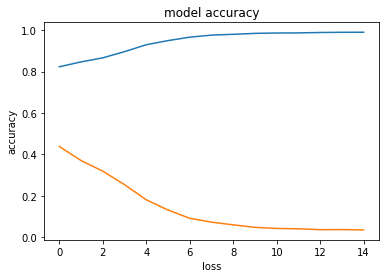

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('loss')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model3.save('/content/drive/MyDrive/DataMem/model_CNN_BiLSTM_emb40_Al_Jazeera_250_7_final.h5')

# BiLSTM

In [ ]:
model2=Sequential()
model2.add(embedding_layer ) 

model2.add(Bidirectional( LSTM(units=250,return_sequences=True)))

model2.add(Flatten())

model2.add(Dense(400, activation='relu'))
model2.add(Dropout(0.2))
#Output  Layer

model2.add(Dense(1, activation='sigmoid')) 

model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model2.summary())
history=model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=10,batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           24664200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 500)           1102000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               8000400   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 33,767,001
Trainable params: 33,767,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
793/793 [==============================] - 81s 99ms/step - loss: 0.3945 - accuracy: 0.8465 -

In [ ]:
model2.save('/content/drive/MyDrive/DataMem/BiLSTM_emb40_Al_Jazeera_final.h5')

In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))


			PERFORMANCE

Accuracy: 0.7916 

              precision    recall  f1-score   support

           0       0.42      0.46      0.44      1119
           1       0.88      0.86      0.87      5220

    accuracy                           0.79      6339
   macro avg       0.65      0.66      0.66      6339
weighted avg       0.80      0.79      0.80      6339



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


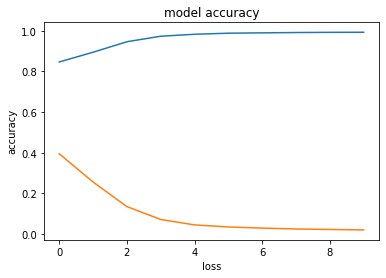

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('loss')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model2.fit(X_tr, y_train,validation_data=(X_tes,y_val) ,epochs=5,verbose=1)

Epoch 1/5
793/793 [==============================] - 80s 101ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 2.4610 - val_accuracy: 0.7992
Epoch 2/5
793/793 [==============================] - 79s 99ms/step - loss: 0.0165 - accuracy: 0.9934 - val_loss: 2.7755 - val_accuracy: 0.8121
Epoch 3/5
793/793 [==============================] - 79s 99ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 3.2372 - val_accuracy: 0.8184
Epoch 4/5
793/793 [==============================] - 79s 99ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 2.9883 - val_accuracy: 0.7880
Epoch 5/5
793/793 [==============================] - 78s 99ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 2.9607 - val_accuracy: 0.7872


In [ ]:
y_test= model2.predict(X_tes)
y_test= np.round(y_test, 0)

print('\t\t\tPERFORMANCE\n')
print('Accuracy:', round(accuracy_score(y_val, y_test), 4), '\n')
print(classification_report(y_val, y_test))

			PERFORMANCE

Accuracy: 0.7872 

              precision    recall  f1-score   support

           0       0.41      0.49      0.45      1119
           1       0.89      0.85      0.87      5220

    accuracy                           0.79      6339
   macro avg       0.65      0.67      0.66      6339
weighted avg       0.80      0.79      0.79      6339



# Sur exemple text

In [ ]:

phrase1 = ['سيد فيصل إحترامي وتعلم']
phrase2=['أمريكا قتلت بالامس معوق رفض رفع يديه فماذا تريد من الشرطة المصرية أن تفعل عندما تتعامل مع مسلحين معهم متفجرات',]

seq1= tokenizer.texts_to_sequences(phrase1)
seq2= tokenizer.texts_to_sequences(phrase2)
data1 = pad_sequences(seq1, maxlen= 40 , padding='post')
data2 = pad_sequences(seq2, maxlen= 40 , padding='post')

prediction1=model2.predict(data1)
prediction2=model2.predict(data2)
print('predection \n  1 : ',prediction1 , '\n 2: ',prediction2)
###################################
##classes= df['languagecomment'].unique()
##print(classes)
##print(np.argmax(prediction))
##pred_name = classes[np.argmax(prediction)]
##print(pred_name)

predection 
  1 :  [[1.2201177e-16]] 
 2:  [[1.]]
